<a href="https://colab.research.google.com/github/yfpang7/dataScience_projects/blob/main/FNN_deepLearningCalculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
import polars as pl
import numpy as np
import polars.selectors as cs
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
import copy
import sklearn.metrics as skm

pl.Config.set_tbl_rows(100)

polars.config.Config

In [84]:
raw_data = (
    pl.DataFrame({
    'x1' : np.random.randint(low=-10, high=11, size=5000,).astype(np.float32),
    'x2' : np.random.randint(low=-10, high=11, size=5000).astype(np.float32),
    })
    .with_columns(
        label = pl.col('x1') + pl.col('x2')
    )
)

# select the features and label
features = raw_data.select('x1', 'x2').to_numpy()
label = raw_data['label'].to_numpy()

In [85]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.33, random_state=42)

In [86]:
# conver to tensors
X_trainT = torch.tensor(X_train, dtype=torch.float32)
X_testT = torch.tensor(X_test, dtype=torch.float32)
y_trainT = torch.tensor(y_train, dtype=torch.float32)
y_testT = torch.tensor(y_test, dtype=torch.float32)

In [87]:
# create pytorch dataset
train_dataset = TensorDataset(X_trainT, y_trainT)
test_dataset = TensorDataset(X_testT, y_testT)

In [88]:
# convert to DataLoader
batchSize = 32
train_loader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0])

In [89]:
# create the model and components
class ANNmodel(nn.Module):
  def __init__(self, input_size, nUnits, nLayers):
    super().__init__()

    # create a dictionary to store the layers
    self.layers = nn.ModuleDict()

    # create the input layer
    self.layers['input'] = nn.Linear(input_size, nUnits)

    # create the hidden layers
    for i in range(nLayers):
      self.layers[f'hidden{i}'] = nn.Linear(nUnits, nUnits)

    # output layer
    self.layers['output'] = nn.Linear(nUnits, 1)

  # forward pass
  def forward(self, x):
    x = F.relu(self.layers['input'](x))
    for i in range(len(self.layers)-2):
      x = F.relu(self.layers[f'hidden{i}'](x))

    # output layer
    x = self.layers['output'](x)

    return x

In [90]:
# test the class
ANNmodel(input_size=2, nUnits=32, nLayers=2)

ANNmodel(
  (layers): ModuleDict(
    (input): Linear(in_features=2, out_features=32, bias=True)
    (hidden0): Linear(in_features=32, out_features=32, bias=True)
    (hidden1): Linear(in_features=32, out_features=32, bias=True)
    (output): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [91]:
# create the model components
def createANNnet(input_size, nUnits, nLayers, learningRate=.01):
  model = ANNmodel(input_size, nUnits, nLayers)
  lossfunc = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=.95)
  return model, lossfunc, optimizer, scheduler

In [92]:
# define a function for training
def trainModel(train_loader, test_loader, input_size, nUnits, nLayers, numepochs=500, toggleDynamic=False):
  training_progress = pl.DataFrame(
      schema=[
          ('iteration', pl.Int64),
          ('epoch', pl.Int64),
          ('train_loss', pl.Float64),
          ('train_acc', pl.Float64),
          ('test_loss', pl.Float64),
          ('test_acc', pl.Float64),
          ('learning_rate', pl.Float64)
      ]
  )
  iteration = 0

  # create the ann model
  model, lossfunc, optimizer, scheduler = createANNnet(input_size, nUnits, nLayers)

  # early stopping parameters
  patience =  15
  best_loss = float('inf')
  no_improve_count = 0
  best_model = None

  # training loop
  for epoch in range(numepochs):
    model.train()
    epoch_train_loss = 0
    epoch_train_acc = 0
    num_batches = 0

    # iterate through the training batches
    for X_trainTL, y_trainTL in train_loader:
      yhat_train = model(X_trainTL)
      train_loss = lossfunc(yhat_train.squeeze(), y_trainTL)
      ## backpropagation
      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()
      ## evaluate training accuracy using percentage error
      train_acc = torch.mean(torch.abs((yhat_train.squeeze() - y_trainTL) / (y_trainTL + 1e-8))) * 100
      ## sum of the loss and accuracy
      epoch_train_loss += train_loss.item()
      epoch_train_acc += train_acc.item()
      num_batches += 1

      # Iteration for each batch
      iteration += 1

    ## update the learning rate after all batches (once per epoch) -  lr decay - if enabled
    if toggleDynamic:
      scheduler.step()
      current_lrs = scheduler.get_last_lr()[0]
    else:
      current_lrs = optimizer.param_groups[0]['lr']

    # evaluate test set
    model.eval()
    test_loss_total = 0
    test_acc_total = 0
    test_batches = 0

    with torch.no_grad():
      for X_testTL, y_testTL in test_loader:
        yhat_test = model(X_testTL)
        test_loss = lossfunc(yhat_test.squeeze(), y_testTL)

        # Calculate test accuracy using the same metric
        ## get the difference = yhat_test.squeeze() - y_testTL
        ## calculate the relative error as fraction = (yhat_test.squeeze() - y_testTL) / (y_testTL + 1e-8)
        ## get the absolute and average across all the samples in the batch
        test_acc = torch.mean(torch.abs((yhat_test.squeeze() - y_testTL) / (y_testTL + 1e-8))) * 100

        test_loss_total += test_loss.item()
        test_acc_total += test_acc.item()
        test_batches += 1

    # Calculate average losses and accuracies for the epoch
    avg_train_loss = epoch_train_loss / num_batches
    avg_train_acc = epoch_train_acc / num_batches
    avg_test_loss = test_loss_total / test_batches
    avg_test_acc = test_acc_total / test_batches

    # Add to training progress
    new_row = pl.DataFrame([{
        'iteration': iteration,
        'epoch': epoch,
        'train_loss': avg_train_loss,
        'train_acc': avg_train_acc,
        'test_loss': avg_test_loss,
        'test_acc': avg_test_acc,
        'learning_rate': current_lrs
    }])
    training_progress = pl.concat([training_progress, new_row])

    # Early stopping check
    if avg_test_loss < best_loss:
      best_loss = avg_test_loss
      no_improve_count = 0
      best_model = copy.deepcopy(model.state_dict())
    else:
      no_improve_count += 1

    if no_improve_count >= patience:
      print(f"Early stopping at epoch {epoch}")
      break

    # Print progress occasionally
    if epoch % 50 == 0 or epoch == numepochs - 1:
      print(f"Epoch {epoch}: Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

  # Load best model
  if best_model is not None:
    model.load_state_dict(best_model)

  return training_progress, model



In [93]:
# train the model
training_progress, trained_model = trainModel(train_loader=train_loader, test_loader=test_loader, input_size=2, nUnits=32, nLayers=2, numepochs=500, toggleDynamic=False)



Epoch 0: Train Loss: 4.4135, Test Loss: 0.0045
Early stopping at epoch 46


In [94]:
# test the model
training_progress.head()

iteration,epoch,train_loss,train_acc,test_loss,test_acc,learning_rate
i64,i64,f64,f64,f64,f64,f64
104,0,4.413533,2.9152e8,0.004456,3.3064904e7,0.01
208,1,0.00334,3.1679e7,0.002384,1.8945358e7,0.01
312,2,0.002403,2.3120e7,0.001454,1.6536045e7,0.01
416,3,0.001572,1.6820e7,0.00322,1.6003659e7,0.01
520,4,0.001386,1.3281e7,0.00116,6.735968e6,0.01


In [95]:
# run the model 20 times
final_training_progress = []

for i in range(20):
  # train the model
  print(f'Training model number: {i+1}')
  training_progress, trained_model = trainModel(train_loader=train_loader, test_loader=test_loader, input_size=2, nUnits=32, nLayers=2, numepochs=500, toggleDynamic=False)

  # annotate experiment number
  training_progress = (
      training_progress
      .with_columns(
          experiment_num=pl.lit(i)
      )
  )

  final_training_progress.append(training_progress)

data = pl.concat(final_training_progress)



Training model number: 1
Epoch 0: Train Loss: 4.5761, Test Loss: 0.0105
Early stopping at epoch 33
Training model number: 2
Epoch 0: Train Loss: 5.3802, Test Loss: 0.0196
Early stopping at epoch 31
Training model number: 3
Epoch 0: Train Loss: 5.5744, Test Loss: 0.0384
Early stopping at epoch 49
Training model number: 4
Epoch 0: Train Loss: 4.1019, Test Loss: 0.0146
Epoch 50: Train Loss: 0.0012, Test Loss: 0.0008
Early stopping at epoch 61
Training model number: 5
Epoch 0: Train Loss: 5.0858, Test Loss: 0.0244
Epoch 50: Train Loss: 0.0001, Test Loss: 0.0001
Early stopping at epoch 78
Training model number: 6
Epoch 0: Train Loss: 4.0964, Test Loss: 0.0058
Epoch 50: Train Loss: 0.0002, Test Loss: 0.0002
Early stopping at epoch 61
Training model number: 7
Epoch 0: Train Loss: 4.5188, Test Loss: 0.0086
Early stopping at epoch 40
Training model number: 8
Epoch 0: Train Loss: 5.3090, Test Loss: 0.0163
Early stopping at epoch 23
Training model number: 9
Epoch 0: Train Loss: 3.7606, Test Loss:

In [96]:
# inspect the final training data
data.head()

iteration,epoch,train_loss,train_acc,test_loss,test_acc,learning_rate,experiment_num
i64,i64,f64,f64,f64,f64,f64,i32
104,0,4.576104,2.6316e8,0.010494,6.018362e7,0.01,0
208,1,0.003579,3.1388e7,0.002028,2.8652496e7,0.01,0
312,2,0.001577,2.2820e7,0.001292,1.3531091e7,0.01,0
416,3,0.000941,1.6385e7,0.000801,1.568305e7,0.01,0
520,4,0.000675,1.2888e7,0.000551,9.838459e6,0.01,0


In [97]:
# evaluate the whole dataset and compute the accuracy
with torch.no_grad():
  predictions = trained_model(torch.tensor(features, dtype=torch.float32))


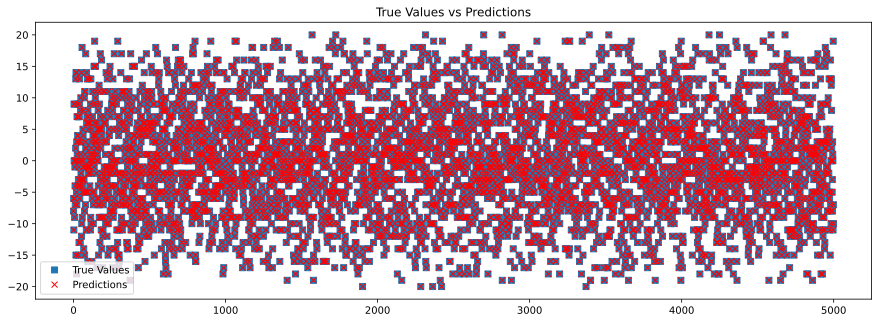

In [98]:
fig = plt.figure(figsize=(15,5))

plt.plot(label, 's', label='True Values')
plt.plot(np.round(predictions.detach().numpy()), 'rx', label='Predictions')
plt.legend()
plt.title('True Values vs Predictions')
plt.show()